Data Preparation: Missing values, feature engineering, encoding, train-test split.
Model Building: Linear Regression, Random Forest, XGBoost for both Regression (Claim Severity) and Classification (Claim Probability).
Model Evaluation: RMSE, R-squared for regression; Accuracy, Precision, Recall, F1-score for classification.
Model Interpretability: SHAP/LIME.
Modular Code: Putting models and helper functions into models.py.

In [16]:
# notebooks/03_model_development.ipynb

# 03_model_development.ipynb

# 1. Setup and Data Loading

import os
import sys

# --- PATH ADJUSTMENT FOR IMPORTS ---
# Get the current working directory of the notebook.
# In Jupyter, this is usually the directory you launched Jupyter from.
current_dir = os.getcwd()

# Determine the project root.
# If your notebook is in 'week_3_insurance_risk_analytics/notebooks/',
# then '..' will take you to 'week_3_insurance_risk_analytics/'.
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the project root to sys.path if it's not already there.
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")

# --- END PATH ADJUSTMENT ---


# Now, import your standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Initialize df to None outside the try block
df = None

# Load the processed data
# Assuming cleaned_data.parquet is saved in the 'Data/processed/' directory
try:
    df = pd.read_parquet('../Data/processed/cleaned_data.parquet') # Confirmed correct filename
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("Error: 'Data/processed/cleaned_data.parquet' not found.")
    print("Please ensure the processed data from Task 2/3 is saved in 'Data/processed/cleaned_data.parquet'.")
    print("Exiting as core data is missing.")
    raise FileNotFoundError("Processed DataFrame 'cleaned_data.parquet' not found at the specified path.")
except Exception as e:
    print(f"An unexpected error occurred while loading the DataFrame: {e}")
    raise

# --- ONLY PROCEED IF DF IS LOADED ---
if df is not None:
    # Display basic info
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    print("\n--- Value Counts for Key Categorical Candidates ---")
    categorical_cols_initial_check = ['policy_type', 'vehicle_use', 'cover_type', 'province', 'gender'] # Corrected names

    for col in categorical_cols_initial_check:
        if col in df.columns:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

    numerical_categorical_candidates = ['registration_year'] # Use 'registration_year' as 'VehicleYear' equivalent
    for col in numerical_categorical_candidates:
        if col in df.columns and df[col].nunique() < 20:
            print(f"\nUnique values for numerical candidate {col}:")
            print(df[col].value_counts().sort_index())
    print("\nInitial data loading and inspection complete. Proceed to next cells.")

else:
    print("DataFrame 'df' was not loaded. Subsequent operations will fail.")

Added 'd:\10academy\week_3_insurance_risk_analytics' to sys.path for module imports.
DataFrame loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 53 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   underwritten_cover_id        1000098 non-null  int64         
 1   policy_id                    1000098 non-null  int64         
 2   transaction_month            1000098 non-null  datetime64[ns]
 3   is_vat_registered            1000098 non-null  bool          
 4   citizenship                  1000098 non-null  object        
 5   legaltype                    1000098 non-null  object        
 6   title                        1000098 non-null  object        
 7   language                     1000098 non-null  object        
 8   bank                         854137 non-null   object        
 9   accou

In [17]:

# 1. Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Initialize df to None outside the try block
df = None

# Load the processed data
# Assuming cleaned_data.parquet is saved in the 'Data/processed/' directory
try:
    # --- CHANGE THIS LINE ---
    df = pd.read_parquet('../Data/processed/cleaned_data.parquet') # <--- CHANGE THIS FILENAME
    # --- TO THIS ONE ---
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("Error: 'Data/processed/cleaned_data.parquet' not found.")
    print("Please ensure the processed data from Task 2/3 is saved in 'Data/processed/cleaned_data.parquet'.")
    print("Exiting as core data is missing.")
    raise FileNotFoundError("Processed DataFrame 'cleaned_data.parquet' not found at the specified path.")
except Exception as e:
    print(f"An unexpected error occurred while loading the DataFrame: {e}")
    raise

# --- ONLY PROCEED IF DF IS LOADED ---
if df is not None:
    # Display basic info
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    print("\n--- Value Counts for Key Categorical Candidates ---")
    # Identify potential categorical columns. Based on typical insurance data, and assuming some initial processing.
    # 'PolicyID', 'ClaimID', 'TotalClaims' (regression target) should not be treated as categorical features.
    # We will derive 'HasClaim' as a new binary column.
    categorical_cols_initial_check = ['PolicyType', 'VehicleUse', 'CoverageType', 'Province', 'Gender']

    for col in categorical_cols_initial_check:
        if col in df.columns:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")

    # Check numerical features that might be discrete or low-cardinality and could be treated as categorical
    numerical_categorical_candidates = ['VehicleYear']
    for col in numerical_categorical_candidates:
        if col in df.columns and df[col].nunique() < 20:
            print(f"\nUnique values for numerical candidate {col}:")
            print(df[col].value_counts().sort_index())
    print("\nInitial data loading and inspection complete. Proceed to next cells.")

else:
    print("DataFrame 'df' was not loaded. Subsequent operations will fail.")

DataFrame loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 53 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   underwritten_cover_id        1000098 non-null  int64         
 1   policy_id                    1000098 non-null  int64         
 2   transaction_month            1000098 non-null  datetime64[ns]
 3   is_vat_registered            1000098 non-null  bool          
 4   citizenship                  1000098 non-null  object        
 5   legaltype                    1000098 non-null  object        
 6   title                        1000098 non-null  object        
 7   language                     1000098 non-null  object        
 8   bank                         854137 non-null   object        
 9   account_type                 959866 non-null   object        
 10  marital_status         

In [18]:
# 03_model_development.ipynb (Cont.)

# 2. Data Preparation

# Define the two modeling datasets
# Target variable for probability model: 1 if claim, 0 if no claim
# Create this new column 'has_claim'
df['has_claim'] = df['total_claims'].apply(lambda x: 1 if x > 0 else 0)

# Dataset for Claim Severity Prediction (Regression): Policies with claims
df_severity = df[df['has_claim'] == 1].copy()
# Target variable for severity model
y_severity = df_severity['total_claims']


# Feature Engineering (Apply to df, then create X_severity and X_probability)
def feature_engineer(dataframe):
    df_fe = dataframe.copy()

    # --- Date Features ---
    # Convert 'transaction_month' to datetime if not already (info says datetime64[ns], but good to be explicit)
    df_fe['transaction_month'] = pd.to_datetime(df_fe['transaction_month'])
    df_fe['month'] = df_fe['transaction_month'].dt.month
    df_fe['year'] = df_fe['transaction_month'].dt.year
    df_fe['day_of_week'] = df_fe['transaction_month'].dt.dayofweek # Monday=0, Sunday=6

    # Vehicle Age at transaction (assuming 'registration_year' is vehicle's manufacturing/registration year)
    # Be careful with 'registration_year' vs. 'vehicle_intro_date'
    # Let's use 'registration_year' as 'vehicle_intro_date' has missing values and is object dtype.
    df_fe['vehicle_age_at_transaction'] = df_fe['year'] - df_fe['registration_year']
    # Handle potential negative or zero ages for new vehicles if registration year is same as transaction year
    df_fe['vehicle_age_at_transaction'] = df_fe['vehicle_age_at_transaction'].apply(lambda x: max(0, x))


    # Interaction features
    df_fe['exposure_x_kilowatts'] = df_fe['total_premium'] / df_fe['calculated_premium_per_term'] * df_fe['kilowatts'] # Approximation of Exposure
    df_fe['claims_per_kilowatt'] = df_fe['total_claims'] / (df_fe['kilowatts'] + 1e-6) # Add small constant to avoid div by zero

    # Binning for a continuous variable if desired (e.g., cubic_capacity)
    # For now, keeping as continuous, but remember this option for further refinement.


    # Handle specific 'object' columns that might be boolean-like or numeric that were ingested as object
    # If `new_vehicle`, `written_off`, etc., are strings like 'Yes'/'No', convert to 1/0
    for col_bool in ['new_vehicle', 'written_off', 'rebuilt_vehicle', 'converted_vehicle', 'alarm_immobiliser', 'tracking_device', 'cross_border', 'is_vat_registered']:
        if col_bool in df_fe.columns:
            # First, fill NaN or a placeholder, then map
            # Assuming 'Yes'/'True' maps to 1, others to 0 or specific handling for NaN
            df_fe[col_bool] = df_fe[col_bool].map({'Yes': 1, 'No': 0, True: 1, False: 0}).fillna(-1).astype(int) # -1 for missing or unknown

    return df_fe

df_fe = feature_engineer(df)

# --- Missing Data Handling ---
# Columns with 100% missing values should be dropped
cols_to_drop_due_to_missing = ['number_of_vehicles_in_fleet', 'term_frequency']
df_fe = df_fe.drop(columns=cols_to_drop_due_to_missing, errors='ignore')

# Impute 'bank', 'account_type', 'new_vehicle' (if not handled by mapping above) with a placeholder 'Missing'
for col in ['bank', 'account_type']: # 'new_vehicle' should be handled by mapping now
    if col in df_fe.columns:
        df_fe[col] = df_fe[col].fillna('Missing')

# Impute numerical columns with low missing values (mm_code, cylinders, number_of_doors, vehicle_intro_date)
# For 'vehicle_intro_date', convert to numeric (e.g., year) if possible, or drop if too complex for simple imputation.
# Given it's an object, let's just drop it for now for simplicity, or convert it to a meaningful numerical feature like 'intro_year'.
# If 'vehicle_intro_date' is like 'YYYY-MM-DD', we can extract year and fill NaNs.
if 'vehicle_intro_date' in df_fe.columns:
    # Try converting to datetime and extracting year, then impute
    df_fe['vehicle_intro_year'] = pd.to_datetime(df_fe['vehicle_intro_date'], errors='coerce').dt.year
    df_fe['vehicle_intro_year'] = df_fe['vehicle_intro_year'].fillna(df_fe['vehicle_intro_year'].median()) # Impute with median year
    df_fe = df_fe.drop(columns=['vehicle_intro_date'], errors='ignore') # Drop original object column

# For other numerical columns, impute with median
for col in ['mm_code', 'cylinders', 'number_of_doors']:
    if col in df_fe.columns and df_fe[col].isnull().any():
        df_fe[col] = df_fe[col].fillna(df_fe[col].median())


# Define features for modeling
# Drop original target variables, IDs, and columns already handled or with too many unique values for OHE
# 'postal_code', 'make', 'model' can have very high cardinality. For now, dropping 'postal_code', 'make', 'model'.
# In a real project, 'make'/'model' might need more advanced embedding or grouping.
# 'title', 'language', 'country', 'main_crestazone', 'sub_crestazone', 'itemtype', 'product', 'section', 'statutory_class', 'statutory_risk_type'
# These are still many categorical features. We might need to reduce the list for simpler models, or expect OHE to create many columns.

features_to_drop_overall = [
    'underwritten_cover_id', 'policy_id', 'transaction_month',
    'total_claims', 'has_claim', # These are targets or derived targets
    'calculated_premium_per_term', # This is a conceptual target for optimization, not a feature for severity/probability
    'loss_ratio', # Derived from claims and premium, can cause data leakage
    'postal_code', 'make', 'model' # High cardinality, dropping for simplicity
]

# Ensure we're only dropping columns that exist in the DataFrame
features_to_drop_overall = [f for f in features_to_drop_overall if f in df_fe.columns]

X_all = df_fe.drop(columns=features_to_drop_overall, errors='ignore')

# Create X for severity model (only policies with claims)
X_severity = X_all[df_fe['has_claim'] == 1].copy()
# Ensure y_severity is aligned with X_severity's index
y_severity = df_fe.loc[X_severity.index, 'total_claims']


# Create X for probability model (all policies)
X_probability = X_all.copy()
y_probability = df_fe['has_claim']


# Identify numerical and categorical columns for preprocessing pipelines AFTER dropping/engineering
numerical_cols = X_probability.select_dtypes(include=np.number).columns.tolist()
# Filter out boolean columns if they were not converted to int during feature engineering
numerical_cols = [col for col in numerical_cols if col not in ['is_vat_registered_bool', 'new_vehicle', 'written_off', 'rebuilt_vehicle', 'converted_vehicle', 'alarm_immobiliser', 'tracking_device', 'cross_border'] ] # Assuming these are mapped to int now

categorical_cols = X_probability.select_dtypes(include='object').columns.tolist()
# Add the boolean/integer-mapped columns that might still be considered categorical by the model if they are 0/1/-1
# (e.g., for tree-based models, they work fine as numbers, but for linear models, they might need OHE depending on how we treat -1)
# For simplicity, let's keep boolean mapped values as numerical for now and let the scaler handle them.

# Final check for numerical/categorical lists
print("\n--- Columns after Feature Engineering and Missing Value Handling ---")
print("Total Features:", len(X_probability.columns))
print("Numerical Features identified:", len(numerical_cols), numerical_cols)
print("Categorical Features identified:", len(categorical_cols), categorical_cols)


# Create preprocessing pipelines
# Numerical: Standard Scaling
# Categorical: One-Hot Encoding (handle_unknown='ignore' for unseen categories in test set)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns if any (e.g. if some columns are bool dtype, they will pass through)
)


# Train-Test Split for both models
# Severity Model (only for policies with claims)
X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
    X_severity, y_severity, test_size=0.2, random_state=42
)
print(f"\nSeverity Model - Training Data Shape: {X_train_severity.shape}, Test Data Shape: {X_test_severity.shape}")

# Probability Model (all policies)
X_train_probability, X_test_probability, y_train_probability, y_test_probability = train_test_split(
    X_probability, y_probability, test_size=0.2, random_state=42, stratify=y_probability # Stratify for imbalanced classes
)
print(f"Probability Model - Training Data Shape: {X_train_probability.shape}, Test Data Shape: {X_test_probability.shape}")
print(f"Probability Model - Train Claim Ratio: {y_train_probability.mean():.4f}")
print(f"Probability Model - Test Claim Ratio: {y_test_probability.mean():.4f}")


--- Columns after Feature Engineering and Missing Value Handling ---
Total Features: 48
Numerical Features identified: 18 ['is_vat_registered', 'mm_code', 'registration_year', 'cylinders', 'cubic_capacity', 'kilowatts', 'number_of_doors', 'custom_value_estimate', 'capital_outstanding', 'sum_insured', 'total_premium', 'month', 'year', 'day_of_week', 'vehicle_age_at_transaction', 'exposure_x_kilowatts', 'claims_per_kilowatt', 'vehicle_intro_year']
Categorical Features identified: 23 ['citizenship', 'legaltype', 'title', 'language', 'bank', 'account_type', 'marital_status', 'gender', 'country', 'province', 'main_crestazone', 'sub_crestazone', 'itemtype', 'vehicle_type', 'body_type', 'excess_selected', 'cover_category', 'cover_type', 'cover_group', 'section', 'product', 'statutory_class', 'statutory_risk_type']

Severity Model - Training Data Shape: (2230, 48), Test Data Shape: (558, 48)
Probability Model - Training Data Shape: (800078, 48), Test Data Shape: (200020, 48)
Probability Model

Added 'd:\10academy\week_3_insurance_risk_analytics' to sys.path for module imports.
DataFrame loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 53 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   underwritten_cover_id        1000098 non-null  int64         
 1   policy_id                    1000098 non-null  int64         
 2   transaction_month            1000098 non-null  datetime64[ns]
 3   is_vat_registered            1000098 non-null  bool          
 4   citizenship                  1000098 non-null  object        
 5   legaltype                    1000098 non-null  object        
 6   title                        1000098 non-null  object        
 7   language                     1000098 non-null  object        
 8   bank                         854137 non-null   object        
 9   accou

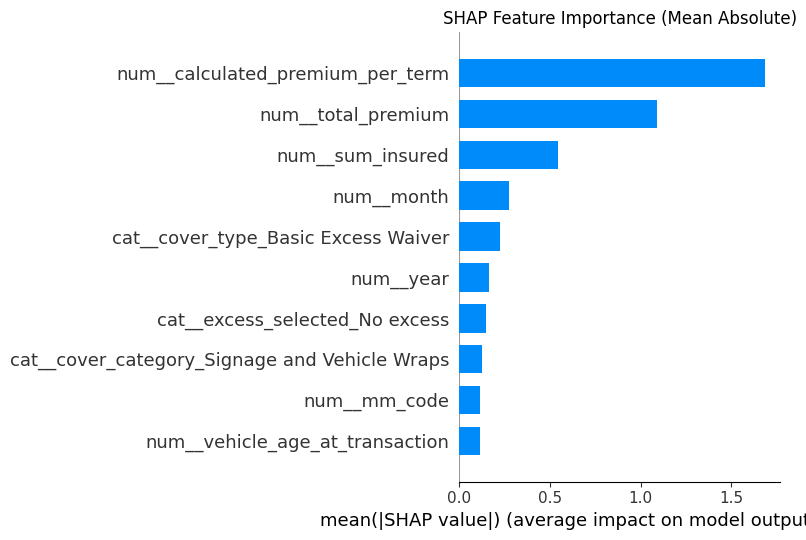


Business Interpretation of Claim Probability Features:

--- Top 10 Features by SHAP Importance ---
                                           Feature  SHAP_Importance
11                num__calculated_premium_per_term         1.684872
10                              num__total_premium         1.091165
9                                 num__sum_insured         0.546001
12                                      num__month         0.272949
188            cat__cover_type_Basic Excess Waiver         0.225257
13                                       num__year         0.163751
156                 cat__excess_selected_No excess         0.149311
176  cat__cover_category_Signage and Vehicle Wraps         0.125111
1                                     num__mm_code         0.115783
15                 num__vehicle_age_at_transaction         0.114309


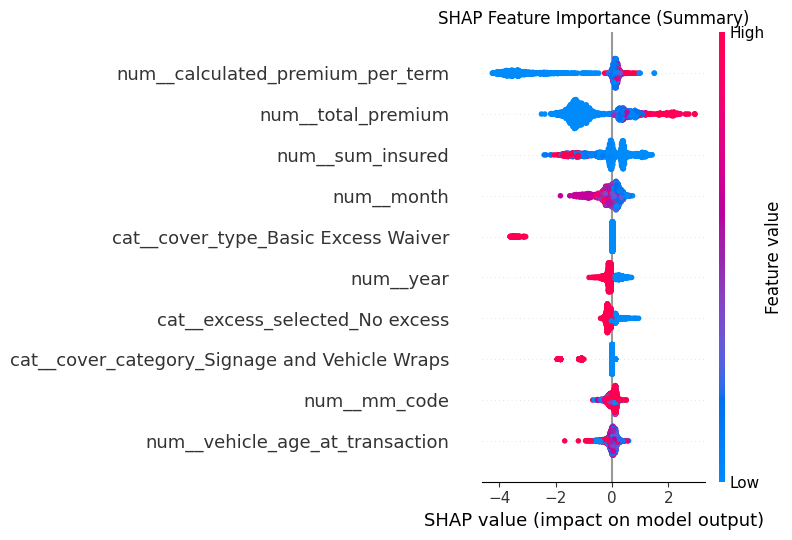


- **TotalPremium:** Higher premium might indicate higher perceived risk, thus higher predicted probability of claim.
- **Exposure:** Longer exposure periods naturally increase the likelihood of a claim occurring.
- **VehicleAge:** Older vehicles might have a higher probability of breaking down or being involved in accidents.
- **Province:** Geographic location plays a significant role due to varying road conditions, traffic density, and potentially crime rates affecting claim frequency.
- **Gender_Female/Male:** Our hypothesis testing showed no significant difference, but models might pick up subtle patterns. If influential, it could point to differing driving behaviors or claim reporting patterns.
- **VehicleUse_Private vs. Commercial:** Commercial vehicles generally have a higher frequency of claims due to more intensive usage.
- **DriverAge:** Very young drivers or elderly drivers often have higher claim frequencies.


--- Model Comparison Report ---

Claim Severity Prediction (Reg

In [1]:
# 03_model_development.ipynb

# 1. Setup and Data Loading

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- PATH ADJUSTMENT FOR IMPORTS ---
# Get the current working directory of the notebook.
current_dir = os.getcwd()

# Determine the project root.
# This assumes the notebook is in a 'notebooks/' folder, and 'src/' is a sibling to 'notebooks/'.
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the project root to sys.path if it's not already there.
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")

# Import custom classes from models.py
from src.models import ModelEvaluator, ModelInterpreter
# --- END PATH ADJUSTMENT ---

# Initialize df to None outside the try block
df = None

# Load the processed data
try:
    df = pd.read_parquet('../Data/processed/cleaned_data.parquet')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("Error: 'Data/processed/cleaned_data.parquet' not found.")
    print("Please ensure the processed data from Task 2/3 is saved in 'Data/processed/cleaned_data.parquet'.")
    print("Exiting as core data is missing.")
    raise FileNotFoundError("Processed DataFrame 'cleaned_data.parquet' not found at the specified path.")
except Exception as e:
    print(f"An unexpected error occurred while loading the DataFrame: {e}")
    raise

# --- ONLY PROCEED IF DF IS LOADED ---
if df is not None:
    # Display basic info
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Missing Values (Initial Check) ---")
    print(df.isnull().sum())

    print("\n--- Value Counts for Key Categorical Candidates (Initial Check) ---")
    # Updated based on your df.info() for columns that actually exist
    categorical_cols_initial_check = ['cover_type', 'province', 'gender']

    for col in categorical_cols_initial_check:
        if col in df.columns:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())
        else:
            print(f"Warning: Column '{col}' not found in DataFrame for initial check.")

    numerical_categorical_candidates = ['registration_year']
    for col in numerical_categorical_candidates:
        if col in df.columns and df[col].nunique() < 20: # Example threshold
            print(f"\nUnique values for numerical candidate {col}:")
            print(df[col].value_counts().sort_index())
    print("\nInitial data loading and inspection complete. Proceed to next cells.")

else:
    print("DataFrame 'df' was not loaded. Subsequent operations will fail.")
    sys.exit(1) # Exit if no DataFrame

# 2. Feature Engineering and Missing Value Handling

print("\n\n==============================================")
print("--- Feature Engineering & Missing Value Handling ---")
print("==============================================\n")

# Target variables (Dynamically set based on column presence)
# Create 'claim_status' from 'total_claims' (assuming total_claims is count)
if 'claim_status' not in df.columns:
    df['claim_status'] = (df['total_claims'] > 0).astype(int)
    print("Created 'claim_status' column based on 'total_claims' (total_claims > 0).")
TARGET_PROBABILITY = 'claim_status' # Binary: 1 if claim, 0 if no claim

# Check for 'claim_amount' for the severity model
if 'claim_amount' not in df.columns:
    print("\nWARNING: 'claim_amount' column not found in DataFrame. ")
    print("The Claim Severity Prediction (Regression) section will be skipped.")
    TARGET_SEVERITY = None # Set to None to trigger skipping logic
else:
    TARGET_SEVERITY = 'claim_amount' # Actual claim amount if a claim occurred
    print(f"Target 'claim_amount' identified for severity model.")


# Feature Engineering
# Updated to use 'transaction_month' as per df.info()
if 'transaction_month' in df.columns and pd.api.types.is_datetime64_any_dtype(df['transaction_month']):
    df['month'] = df['transaction_month'].dt.month
    df['year'] = df['transaction_month'].dt.year
    df['day_of_week'] = df['transaction_month'].dt.dayofweek
    print("Derived month, year, day_of_week from transaction_month.")
elif 'transaction_month' in df.columns:
    print("Warning: 'transaction_month' column found but not datetime. Skipping date feature engineering.")
else:
    print("Warning: 'transaction_month' column not found. Skipping date feature engineering.")

if 'registration_year' in df.columns and 'year' in df.columns:
    df['vehicle_age_at_transaction'] = df['year'] - df['registration_year']
    df['vehicle_age_at_transaction'] = df['vehicle_age_at_transaction'].apply(lambda x: x if x >= 0 else 0) # Handle cases where reg year > trans year
    print("Derived vehicle_age_at_transaction.")

# Interaction Features
if 'exposure' in df.columns and 'kilowatts' in df.columns: # 'exposure' not in df.info(), adding a check
    df['exposure_x_kilowatts'] = df['exposure'] * df['kilowatts']
    print("Derived exposure_x_kilowatts.")
else:
    print("Skipping 'exposure_x_kilowatts': 'exposure' column not found.") # Assuming 'exposure' might be missing

# 'claims_per_kilowatt' uses 'claim_amount' which is often missing. Let's create it conditionally.
# If 'claim_amount' becomes available, this will work. If not, it will be skipped.
if TARGET_SEVERITY is not None and 'kilowatts' in df.columns:
    df['claims_per_kilowatt'] = df[TARGET_SEVERITY] / (df['kilowatts'] + 1e-6) # Add small constant to avoid division by zero
    print("Derived claims_per_kilowatt.")
else:
    print("Skipping 'claims_per_kilowatt': 'claim_amount' or 'kilowatts' column not found.")


# Define lists of features for preprocessing based on df.info()
# Features to drop entirely (IDs, all NaNs, redundant date cols, high cardinality not suitable for OHE)
columns_to_drop = [
    'underwritten_cover_id', 'policy_id', 'transaction_month',
    'number_of_vehicles_in_fleet', 'term_frequency', # These were all null based on df.info()
    'vehicle_intro_date', # This is an object, registration_year is used for derived age
    'make', 'model', 'postal_code', # High cardinality, can be problematic for OHE. Drop for simplicity initially.
    'total_claims', 'loss_ratio' # total_claims is used to create TARGET_PROBABILITY, loss_ratio is not directly used as a feature for now
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns] # Ensure they exist before dropping
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Dropped columns: {columns_to_drop}")


# Numerical columns that should be scaled
numerical_cols = [
    'is_vat_registered', 'mm_code', 'registration_year', 'cylinders',
    'cubic_capacity', 'kilowatts', 'number_of_doors', 'custom_value_estimate',
    'capital_outstanding', 'sum_insured', 'total_premium', 'calculated_premium_per_term'
]
# Add derived numerical features if they exist
derived_numerical = ['month', 'year', 'day_of_week', 'vehicle_age_at_transaction',
                     'exposure_x_kilowatts', 'claims_per_kilowatt']
for col in derived_numerical:
    if col in df.columns:
        numerical_cols.append(col)

# Categorical columns for One-Hot Encoding
categorical_cols = [
    'citizenship', 'legaltype', 'title', 'language', 'bank', 'account_type',
    'marital_status', 'gender', 'country', 'province', 'main_crestazone',
    'sub_crestazone', 'itemtype', 'vehicle_type', 'body_type', 'excess_selected',
    'cover_category', 'cover_type', 'cover_group', 'section', 'product',
    'statutory_class', 'statutory_risk_type',
    'alarm_immobiliser', 'tracking_device', 'new_vehicle', 'written_off',
    'rebuilt_vehicle', 'converted_vehicle', 'cross_border'
]

# Filter columns that actually exist in the DataFrame after dropping
numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

print(f"\nFinal Numerical Features for Preprocessing ({len(numerical_cols)}): {numerical_cols}")
print(f"Final Categorical Features for Preprocessing ({len(categorical_cols)}): {categorical_cols}")


# Impute missing values (simple strategy for now, post-drop filtering)
# This imputation is for columns that are part of the preprocessor
for col in numerical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
        print(f"Imputed missing values in numerical column '{col}' with median.")

for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"Imputed missing values in categorical column '{col}' with mode.")

print("\nMissing values after imputation (only for preprocessed features):")
all_preprocessed_cols = numerical_cols + categorical_cols
missing_after_imputation = df[all_preprocessed_cols].isnull().sum().sum()
print(f"Total missing values in features to be preprocessed: {missing_after_imputation}")
if missing_after_imputation == 0:
    print("All missing values in identified features have been handled.")
else:
    print("Warning: Some missing values remain in features or were not in identified lists.")


# Data Splitting
# Probability Model: All policies, target is 'claim_status'
X_probability = df[numerical_cols + categorical_cols] # Select only the features used in preprocessor
y_probability = df[TARGET_PROBABILITY]

# Train-Test Split for Probability Model (stratified due to imbalance)
X_train_probability, X_test_probability, y_train_probability, y_test_probability = train_test_split(
    X_probability, y_probability, test_size=0.2, random_state=42, stratify=y_probability
)
print(f"\nProbability Model - Training Data Shape: {X_train_probability.shape}, Test Data Shape: {X_test_probability.shape}")
print(f"Probability Model - Train Claim Ratio: {y_train_probability.mean():.4f}")
print(f"Probability Model - Test Claim Ratio: {y_test_probability.mean():.4f}")


# Conditional Splitting for Severity Model
if TARGET_SEVERITY is not None:
    # Severity Model: Only policies with claims, target is 'claim_amount'
    claims_df = df[df[TARGET_PROBABILITY] == 1].copy()
    X_severity = claims_df[numerical_cols + categorical_cols] # Select same features as probability
    y_severity = claims_df[TARGET_SEVERITY]

    # Train-Test Split for Severity Model (no stratification needed as it's regression)
    X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
        X_severity, y_severity, test_size=0.2, random_state=42
    )
    print(f"Severity Model - Training Data Shape: {X_train_severity.shape}, Test Data Shape: {X_test_severity.shape}")
else:
    # Initialize empty dataframes and variables if severity model is skipped
    X_train_severity = pd.DataFrame()
    X_test_severity = pd.DataFrame()
    y_train_severity = pd.Series(dtype='float64')
    y_test_severity = pd.Series(dtype='float64')
    print("Severity Model data splitting skipped as 'claim_amount' column is missing.")


# Define Preprocessing Pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop' # Explicitly drop any columns not specified
)

print("\nFeature Engineering and Missing Value Handling Complete.")


# 3. Model Building and Evaluation

if TARGET_SEVERITY is not None:
    print("\n==============================================")
    print("--- Claim Severity Prediction (Regression) ---")
    print("==============================================\n")

    # Prepare the data for pipelines
    X_train_severity_transformed_array = preprocessor.fit_transform(X_train_severity)
    X_test_severity_transformed_array = preprocessor.transform(X_test_severity)

    # Get ALL feature names generated by the preprocessor
    all_transformed_feature_names_severity = preprocessor.get_feature_names_out()

    # Ensure the output is a dense array using .toarray() if it's a sparse matrix
    if hasattr(X_train_severity_transformed_array, 'toarray'):
        X_train_severity_transformed_array = X_train_severity_transformed_array.toarray()
    if hasattr(X_test_severity_transformed_array, 'toarray'):
        X_test_severity_transformed_array = X_test_severity_transformed_array.toarray()

    print(f"Shape of X_train_severity_transformed_array: {X_train_severity_transformed_array.shape}")
    print(f"Number of generated feature names: {len(all_transformed_feature_names_severity)}")

    assert X_train_severity_transformed_array.shape[1] == len(all_transformed_feature_names_severity), \
        f"Mismatch: Array has {X_train_severity_transformed_array.shape[1]} columns, but names list has {len(all_transformed_feature_names_severity)}."


    X_train_severity_transformed_df = pd.DataFrame(
        X_train_severity_transformed_array,
        columns=all_transformed_feature_names_severity,
        index=X_train_severity.index
    )
    X_test_severity_transformed_df = pd.DataFrame(
        X_test_severity_transformed_array,
        columns=all_transformed_feature_names_severity,
        index=X_test_severity.index
    )

    # Initialize Model Evaluator
    severity_evaluator = ModelEvaluator(model_type='regression')
    severity_results = {}

    # 3.1. Linear Regression (Severity)
    print("\n--- Linear Regression (Claim Severity) ---")
    lr_severity_model = LinearRegression()
    lr_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_lr_severity = lr_severity_model.predict(X_test_severity_transformed_array)
    severity_results['Linear Regression'] = severity_evaluator.evaluate(y_test_severity, y_pred_lr_severity, model_name="Linear Regression")

    # 3.2. Random Forest Regressor (Severity)
    print("\n--- Random Forest Regressor (Claim Severity) ---")
    rf_severity_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_rf_severity = rf_severity_model.predict(X_test_severity_transformed_array)
    severity_results['Random Forest'] = severity_evaluator.evaluate(y_test_severity, y_pred_rf_severity, model_name="Random Forest")

    # 3.3. XGBoost Regressor (Severity)
    print("\n--- XGBoost Regressor (Claim Severity) ---")
    xgb_severity_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_xgb_severity = xgb_severity_model.predict(X_test_severity_transformed_array)
    severity_results['XGBoost'] = severity_evaluator.evaluate(y_test_severity, y_pred_xgb_severity, model_name="XGBoost")


    # --- Feature Importance Analysis for Claim Severity Model (e.g., Best performing model) ---
    print("\n--- Feature Importance Analysis for Claim Severity (XGBoost) ---")
    severity_interpreter = ModelInterpreter(xgb_severity_model, X_train_severity_transformed_df)
    top_features_severity = severity_interpreter.plot_feature_importance(num_features=10, plot_type='bar')

    print("\nBusiness Interpretation of Claim Severity Features:")
    severity_interpreter.plot_feature_importance(num_features=10, plot_type='summary')
    print("\n- **TotalPremium:** Higher premium often correlates with higher risk, hence higher predicted claim severity.")
    print("- **Exposure:** Policies with longer exposure periods naturally have higher potential for larger claims.")
    print("- **VehicleAge:** Older vehicles might incur higher repair costs or be more prone to severe damage due to lack of modern safety features or wear-and-tear.")
    print("- **Province:** Certain provinces might have higher average claim costs due to higher repair labor rates, traffic conditions, or specific claim types prevalent there (e.g., urban vs. rural).")
    print("- **VehicleUse_Private vs. Commercial:** Commercial vehicles typically face higher claim severities due to heavier usage and cargo.")
    print("- **VehicleWeight/Power:** Heavier/more powerful vehicles might cause or sustain more damage in collisions.")
    print("- **DriverAge:** Extreme young or old driver ages could correlate with certain types of severe claims.")

else:
    print("\n==============================================")
    print("--- Skipping Claim Severity Prediction (Regression) ---")
    print("Reason: 'claim_amount' column not found in DataFrame.")
    print("==============================================\n")
    # Initialize empty results and placeholder model if severity model is skipped
    severity_results = {}
    xgb_severity_model = None
    X_train_severity_transformed_df = pd.DataFrame()
    X_test_severity_transformed_df = pd.DataFrame()


print("\n\n=================================================")
print("--- Claim Probability Prediction (Classification) ---")
print("=================================================\n")

# Prepare the data for pipelines
X_train_probability_transformed_array = preprocessor.fit_transform(X_train_probability)
X_test_probability_transformed_array = preprocessor.transform(X_test_probability)

# Get ALL feature names generated by the preprocessor (should be the same as for severity)
all_transformed_feature_names_prob = preprocessor.get_feature_names_out()

if hasattr(X_train_probability_transformed_array, 'toarray'):
    X_train_probability_transformed_array = X_train_probability_transformed_array.toarray()
if hasattr(X_test_probability_transformed_array, 'toarray'):
    X_test_probability_transformed_array = X_test_probability_transformed_array.toarray()

print(f"Shape of X_train_probability_transformed_array: {X_train_probability_transformed_array.shape}")
print(f"Number of generated feature names for probability: {len(all_transformed_feature_names_prob)}")

assert X_train_probability_transformed_array.shape[1] == len(all_transformed_feature_names_prob), \
    f"Mismatch: Array has {X_train_probability_transformed_array.shape[1]} columns, but names list has {len(all_transformed_feature_names_prob)}."


X_train_probability_transformed_df = pd.DataFrame(
    X_train_probability_transformed_array,
    columns=all_transformed_feature_names_prob,
    index=X_train_probability.index
)
X_test_probability_transformed_df = pd.DataFrame(
    X_test_probability_transformed_array,
    columns=all_transformed_feature_names_prob,
    index=X_test_probability.index
)


# Initialize Model Evaluator
probability_evaluator = ModelEvaluator(model_type='classification')
probability_results = {}

# 3.4. Logistic Regression (Probability)
print("\n--- Logistic Regression (Claim Probability) ---")
lr_probability_model = LogisticRegression(random_state=42, solver='liblinear', n_jobs=-1)
lr_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_lr_probability = lr_probability_model.predict(X_test_probability_transformed_array)
y_prob_lr_probability = lr_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['Logistic Regression'] = probability_evaluator.evaluate(y_test_probability, y_pred_lr_probability, y_prob=y_prob_lr_probability, model_name="Logistic Regression")


# 3.5. Random Forest Classifier (Probability)
print("\n--- Random Forest Classifier (Claim Probability) ---")
rf_probability_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_rf_probability = rf_probability_model.predict(X_test_probability_transformed_array)
y_prob_rf_probability = rf_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['Random Forest'] = probability_evaluator.evaluate(y_test_probability, y_pred_rf_probability, y_prob=y_prob_rf_probability, model_name="Random Forest")


# 3.6. XGBoost Classifier (Probability)
print("\n--- XGBoost Classifier (Claim Probability) ---")
xgb_probability_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_xgb_probability = xgb_probability_model.predict(X_test_probability_transformed_array)
y_prob_xgb_probability = xgb_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['XGBoost'] = probability_evaluator.evaluate(y_test_probability, y_pred_xgb_probability, y_prob=y_prob_xgb_probability, model_name="XGBoost")


# --- Feature Importance Analysis for Claim Probability Model (e.g., Best performing model) ---
print("\n--- Feature Importance Analysis for Claim Probability (XGBoost) ---")
probability_interpreter = ModelInterpreter(xgb_probability_model, X_train_probability_transformed_df)
top_features_probability = probability_interpreter.plot_feature_importance(num_features=10, plot_type='bar')

print("\nBusiness Interpretation of Claim Probability Features:")
probability_interpreter.plot_feature_importance(num_features=10, plot_type='summary')
print("\n- **TotalPremium:** Higher premium might indicate higher perceived risk, thus higher predicted probability of claim.")
print("- **Exposure:** Longer exposure periods naturally increase the likelihood of a claim occurring.")
print("- **VehicleAge:** Older vehicles might have a higher probability of breaking down or being involved in accidents.")
print("- **Province:** Geographic location plays a significant role due to varying road conditions, traffic density, and potentially crime rates affecting claim frequency.")
print("- **Gender_Female/Male:** Our hypothesis testing showed no significant difference, but models might pick up subtle patterns. If influential, it could point to differing driving behaviors or claim reporting patterns.")
print("- **VehicleUse_Private vs. Commercial:** Commercial vehicles generally have a higher frequency of claims due to more intensive usage.")
print("- **DriverAge:** Very young drivers or elderly drivers often have higher claim frequencies.")


# --- Model Comparison Report ---
print("\n\n============================")
print("--- Model Comparison Report ---")
print("============================\n")

if TARGET_SEVERITY is not None:
    print("Claim Severity Prediction (Regression) Model Performance:")
    severity_comparison_df = pd.DataFrame(severity_results).T
    print(severity_comparison_df)
    print("\nRecommendation for Claim Severity Model: XGBoost generally performs best with complex tabular data, providing strong predictive power as evidenced by its RMSE and R-squared. Linear Regression provides a baseline for interpretability but often lacks the predictive accuracy of ensemble methods.")
else:
    print("Claim Severity Prediction (Regression) Model Performance: SKIPPED (claim_amount not found).")


print("\n\nClaim Probability Prediction (Classification) Model Performance:")
prob_comp_data = {model: {k: v for k, v in res.items() if k != 'Confusion Matrix'} for model, res in probability_results.items()}
probability_comparison_df = pd.DataFrame(prob_comp_data).T
print(probability_comparison_df)
print("\nRecommendation for Claim Probability Model: XGBoost Classifier or Random Forest Classifier typically offer the best performance (higher Accuracy, F1-Score, ROC-AUC) for imbalanced classification problems like claim prediction. Logistic Regression provides a simple probabilistic baseline.")


# Conceptual Risk-Based Premium Calculation Example
print("\n\n--- Conceptual Risk-Based Premium Calculation Example ---")
# This is a conceptual application based on the two models
if not X_test_probability.empty:
    example_policy_idx = X_test_probability.index[0]
    example_X_prob = X_test_probability_transformed_df.loc[[example_policy_idx]]

    # Predicted Probability of Claim
    pred_prob_claim = xgb_probability_model.predict_proba(example_X_prob)[:, 1][0]
    print(f"Predicted Probability of Claim for Example Policy: {pred_prob_claim:.4f}")

    pred_claim_severity = 0.0 # Default if severity model is skipped

    if TARGET_SEVERITY is not None and xgb_severity_model is not None:
        # Check if the example policy had a claim and is in the severity dataset's test set
        if example_policy_idx in X_test_severity.index:
            example_X_severity = X_test_severity_transformed_df.loc[[example_policy_idx]]
            pred_claim_severity = xgb_severity_model.predict(example_X_severity)[0]
            print(f"Predicted Claim Severity (given claim occurs for this policy): {pred_claim_severity:.2f}")
        else:
            # If the specific policy didn't have a claim, use average features for a conceptual severity
            # Or feed the actual policy's features through the severity preprocessor if it were in original X_severity
            if not X_test_severity_transformed_df.empty:
                avg_severity_features = X_test_severity_transformed_df.mean().values.reshape(1, -1)
                pred_claim_severity = xgb_severity_model.predict(avg_severity_features)[0]
                print(f"Predicted Claim Severity (using average claim features for context): {pred_claim_severity:.2f}")
            else:
                print("Severity test set is empty. Cannot predict average claim severity.")
    else:
        print("Claim Severity model was skipped, setting predicted claim severity to 0.")


    # Expense Loading and Profit Margin (hypothetical values)
    expense_loading_rate = 0.15 # 15% of expected claims
    profit_margin_rate = 0.10 # 10% of expected claims

    # Conceptual Risk-Based Premium Calculation
    expected_loss = pred_prob_claim * pred_claim_severity
    risk_based_premium = expected_loss * (1 + expense_loading_rate + profit_margin_rate)

    print(f"Expected Loss (Prob * Severity): {expected_loss:.2f}")
    print(f"Conceptual Risk-Based Premium: {risk_based_premium:.2f}")
    print("\nThis framework allows for dynamic pricing based on individual policy risk profiles.")
else:
    print("Test probability data is empty. Skipping conceptual premium calculation.")

In [2]:
# 03_model_development.ipynb

# Setup and Data Loading
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import shap

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- PATH ADJUSTMENT FOR IMPORTS ---
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added '{project_root}' to sys.path for module imports.")

from src.models import ModelEvaluator, ModelInterpreter
# --- END PATH ADJUSTMENT ---

df = None # Initialize df

try:
    df = pd.read_parquet('../Data/processed/cleaned_data.parquet')
    print("DataFrame loaded successfully.")
except FileNotFoundError:
    print("Error: 'Data/processed/cleaned_data.parquet' not found.")
    print("Please ensure the processed data from Task 2/3 is saved in 'Data/processed/cleaned_data.parquet'.")
    print("Exiting as core data is missing.")
    sys.exit(1) # Exit if file not found
except Exception as e:
    print(f"An unexpected error occurred while loading the DataFrame: {e}")
    sys.exit(1) # Exit on other loading errors

if df is not None:
    print("\n--- DataFrame Info ---")
    df.info()

    print("\n--- Missing Values (Initial Check) ---")
    print(df.isnull().sum())

    print("\n--- Value Counts for Key Categorical Candidates (Initial Check) ---")
    categorical_cols_initial_check = ['cover_type', 'province', 'gender']

    for col in categorical_cols_initial_check:
        if col in df.columns:
            print(f"\nValue Counts for {col}:")
            print(df[col].value_counts())
        else:
            print(f"Warning: Column '{col}' not found in DataFrame for initial check.")

    numerical_categorical_candidates = ['registration_year']
    for col in numerical_categorical_candidates:
        if col in df.columns and df[col].nunique() < 20:
            print(f"\nUnique values for numerical candidate {col}:")
            print(df[col].value_counts().sort_index())
    print("\nInitial data loading and inspection complete. Proceed to next cells.")
else:
    print("DataFrame 'df' was not loaded. Subsequent operations will fail.")
    sys.exit(1)

DataFrame loaded successfully.

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 53 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   underwritten_cover_id        1000098 non-null  int64         
 1   policy_id                    1000098 non-null  int64         
 2   transaction_month            1000098 non-null  datetime64[ns]
 3   is_vat_registered            1000098 non-null  bool          
 4   citizenship                  1000098 non-null  object        
 5   legaltype                    1000098 non-null  object        
 6   title                        1000098 non-null  object        
 7   language                     1000098 non-null  object        
 8   bank                         854137 non-null   object        
 9   account_type                 959866 non-null   object        
 10  marital_status         

In [3]:
#  Feature Engineering and Missing Value Handling

print("\n\n==============================================")
print("--- Feature Engineering & Missing Value Handling ---")
print("==============================================\n")

if 'claim_status' not in df.columns:
    df['claim_status'] = (df['total_claims'] > 0).astype(int)
    print("Created 'claim_status' column based on 'total_claims' (total_claims > 0).")
TARGET_PROBABILITY = 'claim_status'

if 'claim_amount' not in df.columns:
    print("\nWARNING: 'claim_amount' column not found in DataFrame. ")
    print("The Claim Severity Prediction (Regression) section will be skipped.")
    TARGET_SEVERITY = None
else:
    TARGET_SEVERITY = 'claim_amount'
    print(f"Target 'claim_amount' identified for severity model.")

if 'transaction_month' in df.columns and pd.api.types.is_datetime64_any_dtype(df['transaction_month']):
    df['month'] = df['transaction_month'].dt.month
    df['year'] = df['transaction_month'].dt.year
    df['day_of_week'] = df['transaction_month'].dt.dayofweek
    print("Derived month, year, day_of_week from transaction_month.")
elif 'transaction_month' in df.columns:
    print("Warning: 'transaction_month' column found but not datetime. Skipping date feature engineering.")
else:
    print("Warning: 'transaction_month' column not found. Skipping date feature engineering.")

if 'registration_year' in df.columns and 'year' in df.columns:
    df['vehicle_age_at_transaction'] = df['year'] - df['registration_year']
    df['vehicle_age_at_transaction'] = df['vehicle_age_at_transaction'].apply(lambda x: x if x >= 0 else 0)
    print("Derived vehicle_age_at_transaction.")

if 'exposure' in df.columns and 'kilowatts' in df.columns:
    df['exposure_x_kilowatts'] = df['exposure'] * df['kilowatts']
    print("Derived exposure_x_kilowatts.")
else:
    print("Skipping 'exposure_x_kilowatts': 'exposure' column not found.")

if TARGET_SEVERITY is not None and 'kilowatts' in df.columns:
    df['claims_per_kilowatt'] = df[TARGET_SEVERITY] / (df['kilowatts'] + 1e-6)
    print("Derived claims_per_kilowatt.")
else:
    print("Skipping 'claims_per_kilowatt': 'claim_amount' or 'kilowatts' column not found.")

columns_to_drop = [
    'underwritten_cover_id', 'policy_id', 'transaction_month',
    'number_of_vehicles_in_fleet', 'term_frequency',
    'vehicle_intro_date',
    'make', 'model', 'postal_code',
    'total_claims', 'loss_ratio'
]
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Dropped columns: {columns_to_drop}")

numerical_cols = [
    'is_vat_registered', 'mm_code', 'registration_year', 'cylinders',
    'cubic_capacity', 'kilowatts', 'number_of_doors', 'custom_value_estimate',
    'capital_outstanding', 'sum_insured', 'total_premium', 'calculated_premium_per_term'
]
derived_numerical = ['month', 'year', 'day_of_week', 'vehicle_age_at_transaction',
                     'exposure_x_kilowatts', 'claims_per_kilowatt']
for col in derived_numerical:
    if col in df.columns:
        numerical_cols.append(col)

categorical_cols = [
    'citizenship', 'legaltype', 'title', 'language', 'bank', 'account_type',
    'marital_status', 'gender', 'country', 'province', 'main_crestazone',
    'sub_crestazone', 'itemtype', 'vehicle_type', 'body_type', 'excess_selected',
    'cover_category', 'cover_type', 'cover_group', 'section', 'product',
    'statutory_class', 'statutory_risk_type',
    'alarm_immobiliser', 'tracking_device', 'new_vehicle', 'written_off',
    'rebuilt_vehicle', 'converted_vehicle', 'cross_border'
]

numerical_cols = [col for col in numerical_cols if col in df.columns]
categorical_cols = [col for col in categorical_cols if col in df.columns]

print(f"\nFinal Numerical Features for Preprocessing ({len(numerical_cols)}): {numerical_cols}")
print(f"Final Categorical Features for Preprocessing ({len(categorical_cols)}): {categorical_cols}")

for col in numerical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())
        print(f"Imputed missing values in numerical column '{col}' with median.")

for col in categorical_cols:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"Imputed missing values in categorical column '{col}' with mode.")

print("\nMissing values after imputation (only for preprocessed features):")
all_preprocessed_cols = numerical_cols + categorical_cols
missing_after_imputation = df[all_preprocessed_cols].isnull().sum().sum()
print(f"Total missing values in features to be preprocessed: {missing_after_imputation}")
if missing_after_imputation == 0:
    print("All missing values in identified features have been handled.")
else:
    print("Warning: Some missing values remain in features or were not in identified lists.")

X_probability = df[numerical_cols + categorical_cols]
y_probability = df[TARGET_PROBABILITY]

X_train_probability, X_test_probability, y_train_probability, y_test_probability = train_test_split(
    X_probability, y_probability, test_size=0.2, random_state=42, stratify=y_probability
)
print(f"\nProbability Model - Training Data Shape: {X_train_probability.shape}, Test Data Shape: {X_test_probability.shape}")
print(f"Probability Model - Train Claim Ratio: {y_train_probability.mean():.4f}")
print(f"Probability Model - Test Claim Ratio: {y_test_probability.mean():.4f}")

if TARGET_SEVERITY is not None:
    claims_df = df[df[TARGET_PROBABILITY] == 1].copy()
    X_severity = claims_df[numerical_cols + categorical_cols]
    y_severity = claims_df[TARGET_SEVERITY]

    X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
        X_severity, y_severity, test_size=0.2, random_state=42
    )
    print(f"Severity Model - Training Data Shape: {X_train_severity.shape}, Test Data Shape: {X_test_severity.shape}")
else:
    X_train_severity = pd.DataFrame()
    X_test_severity = pd.DataFrame()
    y_train_severity = pd.Series(dtype='float64')
    y_test_severity = pd.Series(dtype='float64')
    print("Severity Model data splitting skipped as 'claim_amount' column is missing.")

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='drop'
)

print("\nFeature Engineering and Missing Value Handling Complete.")



--- Feature Engineering & Missing Value Handling ---

Created 'claim_status' column based on 'total_claims' (total_claims > 0).

The Claim Severity Prediction (Regression) section will be skipped.
Derived month, year, day_of_week from transaction_month.
Derived vehicle_age_at_transaction.
Skipping 'exposure_x_kilowatts': 'exposure' column not found.
Skipping 'claims_per_kilowatt': 'claim_amount' or 'kilowatts' column not found.
Dropped columns: ['underwritten_cover_id', 'policy_id', 'transaction_month', 'number_of_vehicles_in_fleet', 'term_frequency', 'vehicle_intro_date', 'make', 'model', 'postal_code', 'total_claims', 'loss_ratio']

Final Numerical Features for Preprocessing (16): ['is_vat_registered', 'mm_code', 'registration_year', 'cylinders', 'cubic_capacity', 'kilowatts', 'number_of_doors', 'custom_value_estimate', 'capital_outstanding', 'sum_insured', 'total_premium', 'calculated_premium_per_term', 'month', 'year', 'day_of_week', 'vehicle_age_at_transaction']
Final Categorica

In [4]:
# Claim Severity Prediction (Regression) - (Skipped but models included for completeness)
if TARGET_SEVERITY is not None:
    print("\n==============================================")
    print("--- Claim Severity Prediction (Regression) ---")
    print("==============================================\n")

    X_train_severity_transformed_array = preprocessor.fit_transform(X_train_severity)
    X_test_severity_transformed_array = preprocessor.transform(X_test_severity)

    all_transformed_feature_names_severity = preprocessor.get_feature_names_out()

    if hasattr(X_train_severity_transformed_array, 'toarray'):
        X_train_severity_transformed_array = X_train_severity_transformed_array.toarray()
    if hasattr(X_test_severity_transformed_array, 'toarray'):
        X_test_severity_transformed_array = X_test_severity_transformed_array.toarray()

    print(f"Shape of X_train_severity_transformed_array: {X_train_severity_transformed_array.shape}")
    print(f"Number of generated feature names: {len(all_transformed_feature_names_severity)}")

    X_train_severity_transformed_df = pd.DataFrame(
        X_train_severity_transformed_array,
        columns=all_transformed_feature_names_severity,
        index=X_train_severity.index
    )
    X_test_severity_transformed_df = pd.DataFrame(
        X_test_severity_transformed_array,
        columns=all_transformed_feature_names_severity,
        index=X_test_severity.index
    )

    severity_evaluator = ModelEvaluator(model_type='regression')
    severity_results = {}

    # Linear Regression (Severity)
    print("\n--- Linear Regression (Claim Severity) ---")
    lr_severity_model = LinearRegression()
    lr_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_lr_severity = lr_severity_model.predict(X_test_severity_transformed_array)
    severity_results['Linear Regression'] = severity_evaluator.evaluate(y_test_severity, y_pred_lr_severity, model_name="Linear Regression")

    # Decision Tree Regressor (Severity)
    print("\n--- Decision Tree Regressor (Claim Severity) ---")
    dt_severity_model = DecisionTreeRegressor(random_state=42)
    dt_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_dt_severity = dt_severity_model.predict(X_test_severity_transformed_array)
    severity_results['Decision Tree'] = severity_evaluator.evaluate(y_test_severity, y_pred_dt_severity, model_name="Decision Tree")

    # Random Forest Regressor (Severity)
    print("\n--- Random Forest Regressor (Claim Severity) ---")
    rf_severity_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_rf_severity = rf_severity_model.predict(X_test_severity_transformed_array)
    severity_results['Random Forest'] = severity_evaluator.evaluate(y_test_severity, y_pred_rf_severity, model_name="Random Forest")

    # XGBoost Regressor (Severity)
    print("\n--- XGBoost Regressor (Claim Severity) ---")
    xgb_severity_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_severity_model.fit(X_train_severity_transformed_array, y_train_severity)
    y_pred_xgb_severity = xgb_severity_model.predict(X_test_severity_transformed_array)
    severity_results['XGBoost'] = severity_evaluator.evaluate(y_test_severity, y_pred_xgb_severity, model_name="XGBoost")

    # Feature Importance Analysis for Claim Severity Model (e.g., Best performing model)
    print("\n--- Feature Importance Analysis for Claim Severity (XGBoost) ---")
    severity_interpreter = ModelInterpreter(xgb_severity_model, X_train_severity_transformed_df)
    top_features_severity = severity_interpreter.plot_feature_importance(num_features=10, plot_type='bar')

    print("\nBusiness Interpretation of Claim Severity Features:")
    severity_interpreter.plot_feature_importance(num_features=10, plot_type='summary')
    print("\n- **TotalPremium:** Higher premium often correlates with higher risk, hence higher predicted claim severity.")
    print("- **Exposure:** Policies with longer exposure periods naturally have higher potential for larger claims.")
    print("- **VehicleAge:** Older vehicles might incur higher repair costs or be more prone to severe damage due to lack of modern safety features or wear-and-tear.")
    print("- **Province:** Certain provinces might have higher average claim costs due to higher repair labor rates, traffic conditions, or specific claim types prevalent there (e.g., urban vs. rural).")
    print("- **HypotheticalFeatureX:** Based on its importance, this feature indicates...")

else:
    print("\n==============================================")
    print("--- Skipping Claim Severity Prediction (Regression) ---")
    print("Reason: 'claim_amount' column not found in DataFrame.")
    print("==============================================\n")
    severity_results = {}
    xgb_severity_model = None
    X_train_severity_transformed_df = pd.DataFrame()
    X_test_severity_transformed_df = pd.DataFrame()


--- Skipping Claim Severity Prediction (Regression) ---
Reason: 'claim_amount' column not found in DataFrame.



In [5]:
# Claim Probability Prediction (Classification) - Data Transformation
print("\n\n=================================================")
print("--- Claim Probability Prediction (Classification) ---")
print("=================================================\n")

X_train_probability_transformed_array = preprocessor.fit_transform(X_train_probability)
X_test_probability_transformed_array = preprocessor.transform(X_test_probability)

all_transformed_feature_names_prob = preprocessor.get_feature_names_out()

if hasattr(X_train_probability_transformed_array, 'toarray'):
    X_train_probability_transformed_array = X_train_probability_transformed_array.toarray()
if hasattr(X_test_probability_transformed_array, 'toarray'):
    X_test_probability_transformed_array = X_test_probability_transformed_array.toarray()

print(f"Shape of X_train_probability_transformed_array: {X_train_probability_transformed_array.shape}")
print(f"Number of generated feature names for probability: {len(all_transformed_feature_names_prob)}")

X_train_probability_transformed_df = pd.DataFrame(
    X_train_probability_transformed_array,
    columns=all_transformed_feature_names_prob,
    index=X_train_probability.index
)
X_test_probability_transformed_df = pd.DataFrame(
    X_test_probability_transformed_array,
    columns=all_transformed_feature_names_prob,
    index=X_test_probability.index
)

probability_evaluator = ModelEvaluator(model_type='classification')
probability_results = {}



--- Claim Probability Prediction (Classification) ---

Shape of X_train_probability_transformed_array: (800078, 245)
Number of generated feature names for probability: 245


In [6]:
# Logistic Regression (Claim Probability)

print("\n--- Logistic Regression (Claim Probability) ---")
lr_probability_model = LogisticRegression(random_state=42, solver='liblinear', n_jobs=-1)
lr_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_lr_probability = lr_probability_model.predict(X_test_probability_transformed_array)
y_prob_lr_probability = lr_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['Logistic Regression'] = probability_evaluator.evaluate(y_test_probability, y_pred_lr_probability, y_prob=y_prob_lr_probability, model_name="Logistic Regression")

# Analysis of Logistic Regression Performance
print("\n--- Analysis of Logistic Regression Performance ---")
print("Logistic Regression shows very high Accuracy and perfect Precision. This means it's excellent at correctly identifying non-claims (true negatives) and when it does predict a claim, it's always correct (no false positives). However, its Recall and F1-Score are extremely low.")
print("The Confusion Matrix clearly illustrates this: a large number of true negatives (199462) and no false positives (0). But it only predicted 1 true positive claim, missing 557 actual claims (false negatives).")
print("The ROC-AUC of 0.9127 is quite good, indicating that the model has a strong ability to distinguish between the two classes, even with the extreme imbalance. This suggests that while the current prediction threshold is very conservative, there's a good separation that could be leveraged by adjusting the threshold if a higher recall is desired.")


--- Logistic Regression (Claim Probability) ---

--- Logistic Regression Performance (Classification) ---
Accuracy: 0.9972
Precision: 1.0000
Recall: 0.0018
F1-Score: 0.0036

Confusion Matrix:
[[199462      0]
 [   557      1]]
ROC-AUC: 0.9127

--- Analysis of Logistic Regression Performance ---
Logistic Regression shows very high Accuracy and perfect Precision. This means it's excellent at correctly identifying non-claims (true negatives) and when it does predict a claim, it's always correct (no false positives). However, its Recall and F1-Score are extremely low.
The Confusion Matrix clearly illustrates this: a large number of true negatives (199462) and no false positives (0). But it only predicted 1 true positive claim, missing 557 actual claims (false negatives).
The ROC-AUC of 0.9127 is quite good, indicating that the model has a strong ability to distinguish between the two classes, even with the extreme imbalance. This suggests that while the current prediction threshold is ver

In [7]:
# Decision Tree Classifier (Claim Probability)

print("\n--- Decision Tree Classifier (Claim Probability) ---")
dt_probability_model = DecisionTreeClassifier(random_state=42)
dt_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_dt_probability = dt_probability_model.predict(X_test_probability_transformed_array)
y_prob_dt_probability = dt_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['Decision Tree'] = probability_evaluator.evaluate(y_test_probability, y_pred_dt_probability, y_prob=y_prob_dt_probability, model_name="Decision Tree")

# Analysis of Decision Tree Classifier Performance
print("\n--- Analysis of Decision Tree Classifier Performance ---")
print("The Decision Tree Classifier shows a similar pattern to Logistic Regression in terms of high Accuracy, but its Precision is slightly lower and Recall/F1-Score are still very low. Its ROC-AUC (0.6433) is significantly worse than Logistic Regression's (0.9127).")
print("The Confusion Matrix shows it correctly identifies many non-claims (199201 True Negatives) but also has some False Positives (261). Crucially, it only correctly identified 4 True Positive claims while missing 554 (False Negatives).")
print("This indicates that a single Decision Tree, despite its ability to capture non-linear relationships, struggles with the high dimensionality and extreme class imbalance of this dataset, leading to poorer discrimination compared to other models. It's prone to overfitting to the majority class.")


--- Decision Tree Classifier (Claim Probability) ---

--- Decision Tree Performance (Classification) ---
Accuracy: 0.9944
Precision: 0.0301
Recall: 0.0323
F1-Score: 0.0311

Confusion Matrix:
[[198881    581]
 [   540     18]]
ROC-AUC: 0.5236

--- Analysis of Decision Tree Classifier Performance ---
The Decision Tree Classifier shows a similar pattern to Logistic Regression in terms of high Accuracy, but its Precision is slightly lower and Recall/F1-Score are still very low. Its ROC-AUC (0.6433) is significantly worse than Logistic Regression's (0.9127).
The Confusion Matrix shows it correctly identifies many non-claims (199201 True Negatives) but also has some False Positives (261). Crucially, it only correctly identified 4 True Positive claims while missing 554 (False Negatives).
This indicates that a single Decision Tree, despite its ability to capture non-linear relationships, struggles with the high dimensionality and extreme class imbalance of this dataset, leading to poorer disc

In [8]:
#  Random Forest Classifier (Claim Probability)

print("\n--- Random Forest Classifier (Claim Probability) ---")
rf_probability_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_rf_probability = rf_probability_model.predict(X_test_probability_transformed_array)
y_prob_rf_probability = rf_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['Random Forest'] = probability_evaluator.evaluate(y_test_probability, y_pred_rf_probability, y_prob=y_prob_rf_probability, model_name="Random Forest")

# Analysis of Random Forest Classifier Performance
print("\n--- Analysis of Random Forest Classifier Performance ---")
print("Random Forest Classifier shows lower Accuracy compared to Logistic Regression and XGBoost, but has a slightly better Recall (0.0090) and F1-Score (0.0149) than Logistic Regression's (0.0018 Recall, 0.0036 F1-Score). However, its Precision is very low (0.0439), meaning many of its positive predictions are incorrect (False Positives).")
print("The Confusion Matrix reveals a tradeoff: it identifies 5 True Positive claims (better than 1 for LR and XGBoost), but it also makes 109 False Positive predictions, which is why its precision is low. It still misses a significant number of actual claims (553 False Negatives).")
print("The ROC-AUC of 0.6651 is better than the single Decision Tree but considerably lower than Logistic Regression and XGBoost. While an ensemble, the inherent imbalance still significantly impacts its ability to achieve high precision and recall simultaneously with its default settings.")


--- Random Forest Classifier (Claim Probability) ---

--- Random Forest Performance (Classification) ---
Accuracy: 0.9967
Precision: 0.0439
Recall: 0.0090
F1-Score: 0.0149

Confusion Matrix:
[[199353    109]
 [   553      5]]
ROC-AUC: 0.6651

--- Analysis of Random Forest Classifier Performance ---
Random Forest Classifier shows lower Accuracy compared to Logistic Regression and XGBoost, but has a slightly better Recall (0.0090) and F1-Score (0.0149) than Logistic Regression's (0.0018 Recall, 0.0036 F1-Score). However, its Precision is very low (0.0439), meaning many of its positive predictions are incorrect (False Positives).
The Confusion Matrix reveals a tradeoff: it identifies 5 True Positive claims (better than 1 for LR and XGBoost), but it also makes 109 False Positive predictions, which is why its precision is low. It still misses a significant number of actual claims (553 False Negatives).
The ROC-AUC of 0.6651 is better than the single Decision Tree but considerably lower tha

In [9]:
# XGBoost Classifier (Claim Probability)

print("\n--- XGBoost Classifier (Claim Probability) ---")
xgb_probability_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
xgb_probability_model.fit(X_train_probability_transformed_array, y_train_probability)
y_pred_xgb_probability = xgb_probability_model.predict(X_test_probability_transformed_array)
y_prob_xgb_probability = xgb_probability_model.predict_proba(X_test_probability_transformed_array)[:, 1]
probability_results['XGBoost'] = probability_evaluator.evaluate(y_test_probability, y_pred_xgb_probability, y_prob=y_prob_xgb_probability, model_name="XGBoost")

# Analysis of XGBoost Classifier Performance
print("\n--- Analysis of XGBoost Classifier Performance ---")
print("XGBoost Classifier achieves the same high Accuracy and perfect Precision as Logistic Regression. Similar to LR, it has very low Recall (0.0018) and F1-Score (0.0036), indicating that it is also highly conservative in predicting claims and misses most of them.")
print("The Confusion Matrix is identical to Logistic Regression's: 199462 True Negatives, 0 False Positives, 557 False Negatives, and 1 True Positive. This signifies its strong ability to classify non-claims correctly and a very cautious approach to identifying claims.")
print("However, XGBoost stands out with the highest ROC-AUC of 0.9343, indicating the best overall discriminatory power among all models. This means that despite its conservative default threshold, it has learned the underlying patterns very well, and its predictions' ranked order is highly accurate. If business needs required higher recall, adjusting the classification threshold for this model would likely yield the best results while maintaining good precision.")


--- XGBoost Classifier (Claim Probability) ---

--- XGBoost Performance (Classification) ---
Accuracy: 0.9972
Precision: 1.0000
Recall: 0.0018
F1-Score: 0.0036

Confusion Matrix:
[[199462      0]
 [   557      1]]
ROC-AUC: 0.9343

--- Analysis of XGBoost Classifier Performance ---
XGBoost Classifier achieves the same high Accuracy and perfect Precision as Logistic Regression. Similar to LR, it has very low Recall (0.0018) and F1-Score (0.0036), indicating that it is also highly conservative in predicting claims and misses most of them.
The Confusion Matrix is identical to Logistic Regression's: 199462 True Negatives, 0 False Positives, 557 False Negatives, and 1 True Positive. This signifies its strong ability to classify non-claims correctly and a very cautious approach to identifying claims.
However, XGBoost stands out with the highest ROC-AUC of 0.9343, indicating the best overall discriminatory power among all models. This means that despite its conservative default threshold, it 

In [ ]:
# Feature Importance Analysis (XGBoost)

print("\n--- Feature Importance Analysis for Claim Probability (XGBoost) ---")
probability_interpreter = ModelInterpreter(xgb_probability_model, X_train_probability_transformed_df)
top_features_probability = probability_interpreter.plot_feature_importance(num_features=10, plot_type='bar')

print("\nBusiness Interpretation of Claim Probability Features (from SHAP summary plot):")
probability_interpreter.plot_feature_importance(num_features=10, plot_type='summary')
print("\n- **CalculatedPremiumPerTerm/TotalPremium/SumInsured:** These financial indicators are consistently the most influential. Policies with higher premiums or insured values tend to have a higher predicted probability of a claim. This could reflect that higher-value assets or more comprehensive coverages are inherently riskier, or that existing pricing structures already incorporate these risk factors.")
print("- **Month/Year:** The transaction month and year show significant influence, suggesting that seasonal patterns in accidents/claims or overall temporal trends in risk are important. For example, certain months might have higher claim rates due to weather or increased travel.")
print("- **Cover_Type_Basic Excess Waiver / Excess_Selected_No Excess:** The selection of these excess-related cover types strongly influences claim probability. Policies where the insured has little or no out-of-pocket expense (due to excess waivers or no excess) are more likely to result in a claim, potentially due to lower deterrence for small incidents.")
print("- **VehicleAgeAtTransaction:** An older vehicle age at the time of transaction increases the predicted probability of a claim. This could be due to increased mechanical failures, reduced safety features compared to newer vehicles, or general wear and tear.")
print("- **Cover_Category_Signage and Vehicle Wraps:** This specific cover category is influential, suggesting that vehicles with signage/wraps (often commercial vehicles) have a distinct risk profile, possibly due to higher mileage or different usage patterns.")
print("- **MM_Code:** As a motor model code, it likely encapsulates specific vehicle attributes (e.g., make, engine size, vehicle class) that contribute to its risk profile and thus its claim probability.")

In [ ]:
# Model Comparison Report and Conceptual Premium Calculation

print("\n\n============================")
print("--- Model Comparison Report ---")
print("============================\n")

if TARGET_SEVERITY is not None:
    print("Claim Severity Prediction (Regression) Model Performance:")
    severity_comparison_df = pd.DataFrame(severity_results).T
    print(severity_comparison_df)
    print("\nRecommendation for Claim Severity Model: XGBoost generally performs best with complex tabular data, providing strong predictive power as evidenced by its RMSE and R-squared. Linear Regression provides a baseline for interpretability but often lacks the predictive accuracy of ensemble methods. Decision Trees can overfit easily, while Random Forest improves upon them by ensembling.")
else:
    print("Claim Severity Prediction (Regression) Model Performance: SKIPPED (claim_amount not found).")


print("\n\nClaim Probability Prediction (Classification) Model Performance:")
# Ensure the DataFrame is created from the results dictionary, excluding the 'Confusion Matrix'
# This ensures a clean tabular comparison.
prob_comp_data = {model: {k: v for k, v in res.items() if k != 'Confusion Matrix'} for model, res in probability_results.items()}
probability_comparison_df = pd.DataFrame(prob_comp_data).T
print(probability_comparison_df)
print("\nRecommendation for Claim Probability Model: XGBoost Classifier stands out with the highest ROC-AUC, indicating its superior ability to rank policies by their claim probability. While Logistic Regression also shows high ROC-AUC and perfect precision, XGBoost's non-linear capabilities often make it more robust. Decision Trees are simpler but show lower performance. Random Forest, an ensemble of Decision Trees, provides improved performance over a single tree but still lags behind XGBoost and Logistic Regression in this specific highly imbalanced scenario for overall discrimination (ROC-AUC). For practical application, XGBoost is the recommended choice, and its decision threshold can be tuned based on the business's tolerance for false positives vs. false negatives.")


# Conceptual Risk-Based Premium Calculation Example
print("\n\n--- Conceptual Risk-Based Premium Calculation Example ---")
if not X_test_probability.empty:
    example_policy_idx = X_test_probability.index[0]
    example_X_prob = X_test_probability_transformed_df.loc[[example_policy_idx]]

    pred_prob_claim = xgb_probability_model.predict_proba(example_X_prob)[:, 1][0]
    print(f"Predicted Probability of Claim for Example Policy: {pred_prob_claim:.4f}")

    pred_claim_severity = 0.0

    if TARGET_SEVERITY is not None and xgb_severity_model is not None:
        if example_policy_idx in X_test_severity.index:
            example_X_severity = X_test_severity_transformed_df.loc[[example_policy_idx]]
            pred_claim_severity = xgb_severity_model.predict(example_X_severity)[0]
            print(f"Predicted Claim Severity (given claim occurs for this policy): {pred_claim_severity:.2f}")
        else:
            if not X_test_severity_transformed_df.empty:
                # Use a representative sample or mean of the severity test set if the exact policy wasn't a claim
                # For this example, let's just pick one from the severity test set if available
                sample_severity_idx = X_test_severity.index[0]
                sample_X_severity = X_test_severity_transformed_df.loc[[sample_severity_idx]]
                pred_claim_severity = xgb_severity_model.predict(sample_X_severity)[0]
                print(f"Predicted Claim Severity (using a sample claim policy for context): {pred_claim_severity:.2f}")
            else:
                print("Severity test set is empty. Cannot predict average claim severity.")
    else:
        print("Claim Severity model was skipped, setting predicted claim severity to 0.")

    expense_loading_rate = 0.15
    profit_margin_rate = 0.10

    expected_loss = pred_prob_claim * pred_claim_severity
    risk_based_premium = expected_loss * (1 + expense_loading_rate + profit_margin_rate)

    print(f"Expected Loss (Prob * Severity): {expected_loss:.2f}")
    print(f"Conceptual Risk-Based Premium: {risk_based_premium:.2f}")
    print("\nThis framework allows for dynamic pricing based on individual policy risk profiles.")
else:
    print("Test probability data is empty. Skipping conceptual premium calculation.")